# Training Deep Neural Networks

## Importing Libraries

In [2]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## The Vanishing / Exploding Gradients Problem

- In most cases, during back propagation, gradients keep reducing as the algorithm progresses to lower layers of the NN. This leaves the lower layer connection weights virtually unchanged and training fails to converge. This is known as the **Vanishing Gradients** problem.
- Conversely, the opposite can happen and the gradients can keep growing during back-prop. causing the algorithm to diverge. This is known as the **Exploding Gradients** problem, which is known to surface in RNNs.
- Bengio and Glorot (2010) found that the combination of logistic sigmoid activation and weight initialization (using a normal distribution, with mean=0 and std=1) caused the variance of the outputs of each layers was much greater than the variance of the inputs.
- The variance keeps increasing after each layer until the activation function saturates at the top layers. The saturation is further worsened by the fact that the logistic function has a mean of 0.5 and not 0. (tanh has mean of 0 and is a slight improvement over the sigmoid function.)

In [3]:
# Creating a visualization of the Vanishing / Exploding Gradients problem
def logit(z):
    return 1 / (1 + np.exp(-z))

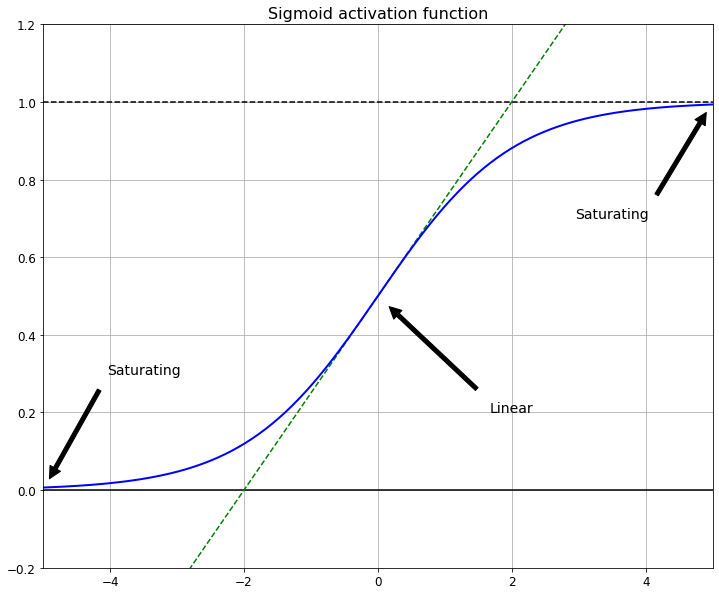

In [20]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(12,10))
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [1, 1], "k--")
plt.plot([0, 0], [-0.2, -0.2], "k-")
plt.plot([-5, 5], [-3/4, 7/4], "g--")
plt.plot(z, logit(z), "b-", linewidth=2)

props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=16)
plt.axis([-5, 5, -0.2, 1.2])
plt.show();

## Glorot and He Initialization